# Chapter 6 -- Polars (Part2)
 

## Topics Covered

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#SAS-Sort-Merge-with-by-group">SAS Sort Merge with by-group </a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Inner-Join">Inner Join </a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Right-Outer-Join">Right Outer Join </a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Left-Outer-Join">Left Outer Join </a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Full-Outer-Join">Full Outer Join </a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Outer-Join-no-Matched-Keys">Outer Join no Matched Keys </a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Outer-Join-no-Matched-Keys-in-Right">Outer Join no Matched Keys in Right</a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Outer-Join-no-Matched-Keys-in-Left">Outer Join no Matched Keys in Left</a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Many-to-Many-Join">Many-to-Many Join</a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Group-by:-split-apply-combine-Introduction">Group by: split-apply-combine Introduction</a>
   
<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Replace-Missing-Values-with-Group-Means">Replace Missing Values with Group Means</a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb?flush_cache=true/#FIRST.variable-and-LAST.variable">FIRST.variable and LAST.variable Processing</a>

<a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Resources">Resources</a>

The usual pre-amble to get packages loaded into the namespace.

In [1]:
import polars as pl
from numpy.random import randn
from pandas import Series, DataFrame, Index
from IPython.display import Image

The display method() defined below is from the Python Data Science Handbook, by Jake VanderPlas, available <a href="http://shop.oreilly.com/product/0636920034919.do"> here </a>.  It is used to render DataFrames side-by-side for comparisons.

In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## SAS Sort Merge with by-group

Start with the example data from SAS' Step-by-Step Programming with Base SAS software doc located <a href="https://support.sas.com/documentation/cdl/en/basess/58133/HTML/default/viewer.htm#a001304305.htm"> here</a> .  

Create the SAS data sets 'left' and 'right'.

````
    /******************************************************/
    /* c07_default_sort_merge.sas                         */
    /******************************************************/
    data left;
       length name $ 32;
       input name $ 1-25 age 27-28 gender $ 30;
       datalines;
    Gunter, Thomas            27 M
    Harbinger, Nicholas       36 M
    Benito, Gisela            32 F
    Rudelich, Herbert         39 M
    Sirignano, Emily          12 F
    Morrison, Michael         32 M
    Morrison, Michael         32 M
    Onieda, Jacqueline        31 F
    ;;;;

    data right;
       length name $ 32;
       input idnumber $ 1-11 name $ 13-40 salary;
       datalines;
    929-75-0218 Gunter, Thomas               27500
    446-93-2122 Harbinger, Nicholas          33900
    228-88-9649 Benito, Gisela               28000
    029-46-9261 Rudelich, Herbert            35000
    442-21-8075 Sirignano, Emily             5000
    321-82-5771 Valpolicella, Vino           88000
    ;;;;
````

The SAS log below shows both data sets sorted by 'name' and subsequently merged on the sort key.  If the keys from both tables match then the observation is merged into a single observation in the output dataset.   

Observations not matching in both input data sets are included and their values are set to missing as illustrated in the SAS output below.  This is the equivalent of a full outer join shown <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Full-Outer-Join"> below</a>.

````
    /******************************************************/
    /* c07_default_sort_merge.sas                         */
    /******************************************************/
    34       proc sort data=left;
    35          by name;
    36       
    37       proc sort data=right;
    38          by name;
    39       
    40       data merge_both;
    41       merge left
    42             right;
    43          by name;

    NOTE: 8 observations were read from "WORK.left"
    NOTE: 6 observations were read from "WORK.right"
    NOTE: Data set "WORK.merge_both" has 9 observation(s) and 5 variable(s)
````

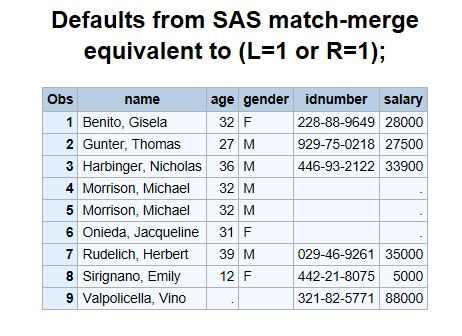

In [3]:
Image(filename=r'img/default_match.jpg')

Construct the DataFrames 'left' containing demographic information for employees and 'right' containing salary information.  They are replicates of the SAS data sets 'left' and 'right' used with the SAS program above.

In [4]:
left = pl.DataFrame({'name': ['Gunter, Thomas', 'Harbinger, Nicholas', 'Benito, Gisela', 'Rudelich, Herbert', \
                              'Sirignano, Emily', 'Morrison, Michael', 'Morrison, Michael', 'Onieda, Jacqueline'],
                     'age':          [27, 36, 32, 39, 22, 32, 32, 31],
                     'gender':       ['M', 'M', 'F', 'M', 'F', 'M', 'M', 'F']})

right = pl.DataFrame({'name': ['Gunter, Thomas', 'Harbinger, Nicholas', \
                               'Benito, Gisela','Rudelich, Herbert', 'Sirignano, Emily', 'Valpolicella, Vino'],
                      'id':           ['929-75-0218', '446-93-2122', \
                                       '228-88-9649', '029-46-9261', '442-21-8075', '321-82-5771'], 
                      'salary':      [27500, 33900, 28000, 35000, 5000, 80000]})

In [5]:
display("left", "right")

name,age,gender
str,i64,str
"""Gunter, Thomas""",27,"""M"""
"""Harbinger, Nicholas""",36,"""M"""
"""Benito, Gisela""",32,"""F"""
"""Rudelich, Herbert""",39,"""M"""
"""Sirignano, Emily""",22,"""F"""
"""Morrison, Michael""",32,"""M"""
"""Morrison, Michael""",32,"""M"""
"""Onieda, Jacqueline""",31,"""F"""
name,id,salary


polars uses two main constructs for joining and merging dataframes:
* [`pl.concat`](https://docs.pola.rs/api/python/dev/reference/api/polars.concat.html): push together based on current order (no join key)
* [`pl.DataFrame.join`](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.join.html): sql-like operations

Consider the SAS log below.  It shows 7 different output data sets created in a single Data Step.  Each are produced below with panda.  

````
    /******************************************************/
    /* c07_create_all_data_sets.sas                       */
    /******************************************************/
    26      data both
    27           right
    28           left
    29           allrows
    30           nomatchl
    31           nomatchr
    32           nomatch;
    33      
    34            merge left(in=l)
    35                   right(in=r);
    36            by name;
    37      
    38      if (l=l and r=1) then output both; *Inner Join;
    39      
    40      if r = 1 then output right; * Right Outer Join;
    41      
    42      if l = 1 then output left;  * Left Outer Join;
    43      
    44      if (l=1 or r=1) then output allrows; *Full Outer Join;
    45      
    46      if (l=0 and r=1) then output nomatchl;
    47      
    48      if (l=1 and r=0) then output nomatchr;
    49      
    50      if (l=0 or r=0) then output nomatch;

    NOTE: 8 observations were read from "WORK.left"
    NOTE: 6 observations were read from "WORK.right"
    NOTE: Data set "WORK.both" has 6 observation(s) and 5 variable(s)
    NOTE: Data set "WORK.right" has 6 observation(s) and 5 variable(s)
    NOTE: Data set "WORK.left" has 8 observation(s) and 5 variable(s)
    NOTE: Data set "WORK.allrows" has 9 observation(s) and 5 variable(s)
    NOTE: Data set "WORK.nomatchl" has 1 observation(s) and 5 variable(s)
    NOTE: Data set "WORK.nomatchr" has 3 observation(s) and 5 variable(s)
    NOTE: Data set "WORK.nomatch" has 4 observation(s) and 5 variable(s)
````

## Inner Join
### If (L=1 and R=1);

An INNER JOIN selects only those rows whose key values are found in both tables.  Another way to say this is the intersection of key values.

````
    /******************************************************/
    /* c07_inner_join.sas                                 */
    /******************************************************/
    37       proc sql;
    38          select monotonic() as row_num
    39                ,*
    40       
    41        from left, right
    42        where left.name = right.name;
````

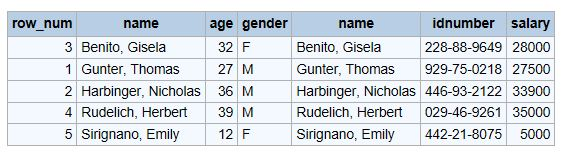

In [6]:
Image(filename='img/inner_join.jpg')

With the polars join() method, how='inner' is the analog to the SAS example above.

The polars 'how' argument for the join() method specifies which keys are to be included in the output table. If a key combination does not appear in either the left or right table then values in the joined table will be NaN for missing.  This is the same as the SAS sort/merge example above. 

Use the how='inner' argument for an INNER JOIN.  This retrieves the intersection of key values from the 'left' and 'right' DataFrames.

In [9]:
both = left.join(right, on='name', how='inner')

In [13]:
# to sort, pick the name
both = both.sort('name')

In [12]:
both

name,age,gender,id,salary
str,i64,str,str,i64
"""Benito, Gisela""",32,"""F""","""228-88-9649""",28000
"""Gunter, Thomas""",27,"""M""","""929-75-0218""",27500
"""Harbinger, Nicholas""",36,"""M""","""446-93-2122""",33900
"""Rudelich, Herbert""",39,"""M""","""029-46-9261""",35000
"""Sirignano, Emily""",22,"""F""","""442-21-8075""",5000


The SAS Data Step eqivalent of an Inner Join.
    
    data both;
    merge left(in=l)
          right(in=r);
    by name;
    
    if (l=1 and r=1) then output both;
    

## Right Outer Join
### if R = 1;

PROC SQL Right Outer Join example.

````
    /******************************************************/
    /* c07_right_outer_join.sas                           */
    /******************************************************/
    38       proc sql;
    39       create table r_outer(drop=old_name) as
    40          select monotonic() as row_num
    41                ,coalesce(left.old_name, right.old_name) as name
    42                ,*
    43          from left (rename=(name=old_name))
    44          right join
    45          right (rename=(name=old_name))
    46        on left.old_name = right.old_name;
    47       
    48        select *
    49        from r_outer;
    50        quit;
````

The COALESCE function coerces the 'name' variable into a single column.  The 'name' column is renamed 'old_name' to provide a join key and is then dropped.  

To produce the output above a second SELECT statement is used to display the single 'name' column in the output.

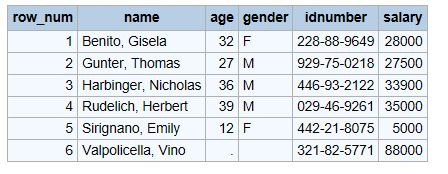

In [15]:
Image(filename='img/right_outer.jpg')

For polars use the how='right' argument for a Right Outer Join.  This returns only those key values found in the 'right' DataFrame with corresponding matches found the 'left' DataFrame.

In [17]:
r_outer = left.join(right, on='name', how='right')

In [18]:
r_outer

age,gender,name,id,salary
i64,str,str,str,i64
27,"""M""","""Gunter, Thomas""","""929-75-0218""",27500
36,"""M""","""Harbinger, Nicholas""","""446-93-2122""",33900
32,"""F""","""Benito, Gisela""","""228-88-9649""",28000
39,"""M""","""Rudelich, Herbert""","""029-46-9261""",35000
22,"""F""","""Sirignano, Emily""","""442-21-8075""",5000
null,null,"""Valpolicella, Vino""","""321-82-5771""",80000


The SAS Data Step equivalent of a RIGHT Outer Join.

````
    78       data r_outer;
    79           merge left(in=l)
    80                 right(in=r);
    81       
    82       if r = 1;
````

## Left Outer Join
### If L = 1;

PROC SQL Left Outer Join example.  See the SAS SQL Right Outer Join example <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#Right-Outer-Join"> above</a> to use the COALESCE function to coerce the name column contributed by both both tables into a single column.

````
    /******************************************************/
    /* c07_left_outer_join.sas                            */
    /******************************************************/
    29       proc sql;
    30          select monotonic() as row_num
    31                ,*
    32          from
    33             left
    34          left join
    35             right
    36        on left.name = right.name;
    37       
    38        quit;
````

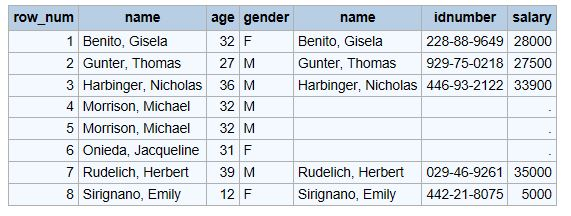

In [19]:
Image(filename='img/left_outer.jpg')

For panda use the how='left' argument for a LEFT OUTER JOIN.  This returns only those key values found in the 'left' DataFrame with corresponding matches found the 'right' DataFrame.

In [21]:
l_outer = left.join(right, on='name', how='left')

In [22]:
l_outer

name,age,gender,id,salary
str,i64,str,str,i64
"""Gunter, Thomas""",27,"""M""","""929-75-0218""",27500
"""Harbinger, Nicholas""",36,"""M""","""446-93-2122""",33900
"""Benito, Gisela""",32,"""F""","""228-88-9649""",28000
"""Rudelich, Herbert""",39,"""M""","""029-46-9261""",35000
"""Sirignano, Emily""",22,"""F""","""442-21-8075""",5000
"""Morrison, Michael""",32,"""M""",null,null
"""Morrison, Michael""",32,"""M""",null,null
"""Onieda, Jacqueline""",31,"""F""",null,null


The SAS Data Step equivalent of a Left Outer Join.

````    
    73      data l_outer;
    74          merge left(in=l)
    75                right(in=r);
    76      
    77      if l = 1;
````

## Full Outer Join
### If (L=1 or R=1);

PROC SQL Full Outer Join exanple.  This is the default behavior for the SORT/MERGE example located at the <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2007%20--%20Pandas%2C%20Part%202.ipynb#SAS-Sort-Merge-with-by-group"> beginning</a> of this notebook.

````
    /******************************************************/
    /* c07_full_outer_join.sas                            */
    /******************************************************/
    6       proc sql;
    7       create table sas_merge(drop=old_name) as
    8       select monotonic() as obs
    9             ,coalesce(left.old_name, right.old_name) as name
    10             ,*
    11          from left (rename=(name=old_name))
    12       full join right (rename=(name=old_name))
    13           on left.old_name = right.old_name;
    14       
    15       select * from sas_merge;   
````

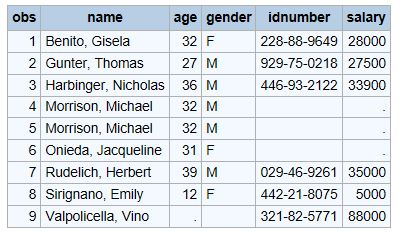

In [23]:
Image(filename='img/full_outer_join.jpg')

In [25]:
merge_both = left.join(right, on='name', how='full')

In [26]:
merge_both

name,age,gender,name_right,id,salary
str,i64,str,str,str,i64
"""Gunter, Thomas""",27,"""M""","""Gunter, Thomas""","""929-75-0218""",27500
"""Harbinger, Nicholas""",36,"""M""","""Harbinger, Nicholas""","""446-93-2122""",33900
"""Benito, Gisela""",32,"""F""","""Benito, Gisela""","""228-88-9649""",28000
"""Rudelich, Herbert""",39,"""M""","""Rudelich, Herbert""","""029-46-9261""",35000
"""Sirignano, Emily""",22,"""F""","""Sirignano, Emily""","""442-21-8075""",5000
"""Morrison, Michael""",32,"""M""",null,null,null
"""Morrison, Michael""",32,"""M""",null,null,null
"""Onieda, Jacqueline""",31,"""F""",null,null,null
null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000


A Full Outer Join is the default behavior for a SAS 'Sort-Merge' with a by-group except in the case of a many-to-many join (see below).  It combines all observations from both data sets.  Said another way, the UNION of all values from both datasets.  

This is also the equivalent to setting the MERGE IN= flag as:

    if (L=1 or R=1) then output merge_both;

````
    34       proc sort data=left;
    35          by name;
    36       
    37       proc sort data=right;
    38          by name;
    39       
    40       data merge_both;
    41       merge left
    42             right;
    43          by name;

    NOTE: 8 observations were read from "WORK.left"
    NOTE: 6 observations were read from "WORK.right"
    NOTE: Data set "WORK.merge_both" has 9 observation(s) and 5 variable(s)
````

## Outer Join no Matched Keys
### if (L=0 or R=0); 

The examples above illustrate joining strategies based on matched key values in the data to be joined.  The next three examples illustrate joining data where keys are not matched.  

Every SQL join is either a Cartesian product join or a sub-set of the Cartesian product join.  Thus requiring a different approach to cases involving non-matched key values.   Some form of WHERE processing is required.  This is where the SAS Data Step with its IN= processing logic is a common pattern.  

PROC SQL can be used as well.

The next three examples use panda's indicator= argument to the pd.merge() method as an analog to the SAS IN= flag.  

For panda the WHERE processing filters utilize <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2005%20--%20Understanding%20Indexes.ipynb#Mixing-.loc-Indexer-with-Boolean-Operators"> boolean comparisons</a>.

Start with the SAS Data Step for no matched keys in either the 'left' or 'right' data sets. 

````
    /******************************************************/
    /* c07_nomatch_left_or_right.sas                      */
    /******************************************************/
    45      data nomatch;
    46            merge left(in=l)
    47                   right(in=r);
    48            by name;
    49      
    50      if (l=0 or r=0);
    51      
    52      title1 "if (L=0 or R=0)";
````        

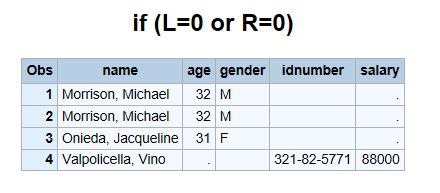

In [27]:
 Image(filename='img/nomatch.jpg')

To figure out whether a value came from left or right in a full join, we can see if that column is null.

Construct the 'nomatch' DataFrame with an Outer Join using the ['name'] column as the join key for both.

In [40]:
def get_join_indicator(df, left_label, right_label):
    return df.with_columns(
        pl.when(pl.col(left_label).is_null() & pl.col(right_label).is_not_null())
          .then(pl.lit('right_only'))
          .when(pl.col(left_label).is_not_null() & pl.col(right_label).is_null())
          .then(pl.lit('left_only'))
          .otherwise(pl.lit('both'))
          .alias('indicator')
    )


In [37]:
nomatch = left.join(right, on='name', how='full')

The 'nomatch' DataFrame displays the nomatch['in= '] column values.  These values are tested with boolean comparisons for the WHERE processing.

In [38]:
nomatch

name,age,gender,name_right,id,salary
str,i64,str,str,str,i64
"""Gunter, Thomas""",27,"""M""","""Gunter, Thomas""","""929-75-0218""",27500
"""Harbinger, Nicholas""",36,"""M""","""Harbinger, Nicholas""","""446-93-2122""",33900
"""Benito, Gisela""",32,"""F""","""Benito, Gisela""","""228-88-9649""",28000
"""Rudelich, Herbert""",39,"""M""","""Rudelich, Herbert""","""029-46-9261""",35000
"""Sirignano, Emily""",22,"""F""","""Sirignano, Emily""","""442-21-8075""",5000
"""Morrison, Michael""",32,"""M""",null,null,null
"""Morrison, Michael""",32,"""M""",null,null,null
"""Onieda, Jacqueline""",31,"""F""",null,null,null
null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000


In [41]:
# left has 'name', right has 'name_right'
nomatch = get_join_indicator(nomatch, 'name', 'name_right')
nomatch

name,age,gender,name_right,id,salary,indicator
str,i64,str,str,str,i64,str
"""Gunter, Thomas""",27,"""M""","""Gunter, Thomas""","""929-75-0218""",27500,"""both"""
"""Harbinger, Nicholas""",36,"""M""","""Harbinger, Nicholas""","""446-93-2122""",33900,"""both"""
"""Benito, Gisela""",32,"""F""","""Benito, Gisela""","""228-88-9649""",28000,"""both"""
"""Rudelich, Herbert""",39,"""M""","""Rudelich, Herbert""","""029-46-9261""",35000,"""both"""
"""Sirignano, Emily""",22,"""F""","""Sirignano, Emily""","""442-21-8075""",5000,"""both"""
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Onieda, Jacqueline""",31,"""F""",null,null,null,"""left_only"""
null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000,"""right_only"""


Using <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2005%20--%20Understanding%20Indexes.ipynb#Mixing-.loc-Indexer-with-Boolean-Operators"> boolean logic</a> and the logical 'or' (|) comparison, select those rows with the value 'left_only' and 'right_only'.

In [42]:
nomatch.filter(
    (pl.col('indicator') == 'left_only') | (pl.col('indicator') == 'right_only')
)

name,age,gender,name_right,id,salary,indicator
str,i64,str,str,str,i64,str
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Onieda, Jacqueline""",31,"""F""",null,null,null,"""left_only"""
null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000,"""right_only"""


Brievity allows:

In [43]:
nomatch.filter(
    pl.col('indicator') != 'both'
)

name,age,gender,name_right,id,salary,indicator
str,i64,str,str,str,i64,str
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Onieda, Jacqueline""",31,"""F""",null,null,null,"""left_only"""
null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000,"""right_only"""


## Outer Join no Matched Keys in Right

Locate the key value rows in the 'right' data set which have no corresponding match in the 'left' data set.

````  
    /******************************************************/
    /* c07_nomatch_right.sas                              */
    /******************************************************/
    12      data nomatchr;
    13            merge left(in=l)
    14                   right(in=r);
    15            by name;
    16      
    17      if (l=0 and r=1);
    18      
     
````

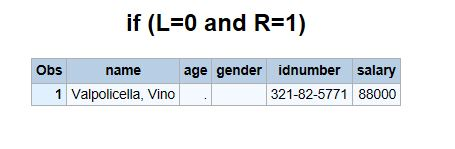

In [44]:
 Image(filename='img/nomatch_in_right.jpg')

Locate the rows in the 'right' DataFrame which have no corresonding key value matches in the 'left' DataFrame.

Use a boolean comparison to find key value rows contributed by the 'right' DataFrame.  In other words, key values in the 'right' DataFrame not found in the 'left' DataFrame.

In [45]:
nomatch.filter(
    pl.col('indicator') == 'right_only'
)

name,age,gender,name_right,id,salary,indicator
str,i64,str,str,str,i64,str
null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000,"""right_only"""


## Outer Join no Matched Keys in Left

Locate the key value rows in the 'left' data set having no corresonding match in the 'right' data set.

````
    /******************************************************/
    /* c07_nomatch_left.sas                               */
    /******************************************************/
    96      data nomatchl;
    97            merge left(in=l)
    98                   right(in=r);
    99            by name;
    100      
    101      if (l=1 and r=0);
    102      
````

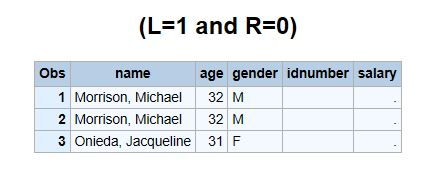

In [46]:
Image(filename='img/nomatch_in_left.jpg')

Locate the key value rows in the 'left' DataFrame which have no corresonding matches in the 'right' DataFrame.

Use a boolean comparison to find key values rows contributed by the 'left' DataFrame only.  In other words key values in the 'left' DataFrame not found in the 'right' DataFrame.

In [47]:
nomatch.filter(
    pl.col('indicator') == 'left_only'
)

name,age,gender,name_right,id,salary,indicator
str,i64,str,str,str,i64,str
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Onieda, Jacqueline""",31,"""F""",null,null,null,"""left_only"""


## Many-to-Many Join

Construct the DataFrames with duplicate ['name'] column values in each. 

In [49]:
left = pl.DataFrame({'name': ['Gunter, Thomas', 'Harbinger, Nicholas', 'Benito, Gisela', 'Rudelich, Herbert', \
                              'Sirignano, Emily', 'Morrison, Michael', 'Morrison, Michael', 'Onieda, Jacqueline'],
                     'age':          [27, 36, 32, 39, 22, 32, 32, 31],
                     'gender':       ['M', 'M', 'F', 'M', 'F', 'M', 'M', 'F']})

right = pl.DataFrame({'name': ['Gunter, Thomas', 'Harbinger, Nicholas', \
                               'Benito, Gisela','Rudelich, Herbert', 'Sirignano, Emily', 'Valpolicella, Vino', \
                                'Morrison, Michael', 'Morrison, Michael'],
                      'id':           ['929-75-0218', '446-93-2122', \
                                       '228-88-9649', '029-46-9261', '442-21-8075', '321-82-5771', \
                                       '222-33-4444', '222-33-4444'], 
                      'salary':      [27500, 33900, 28000, 35000, 5000, 80000, 75000, 75000]})

In [50]:
display("left", "right")

name,age,gender
str,i64,str
"""Gunter, Thomas""",27,"""M"""
"""Harbinger, Nicholas""",36,"""M"""
"""Benito, Gisela""",32,"""F"""
"""Rudelich, Herbert""",39,"""M"""
"""Sirignano, Emily""",22,"""F"""
"""Morrison, Michael""",32,"""M"""
"""Morrison, Michael""",32,"""M"""
"""Onieda, Jacqueline""",31,"""F"""
name,id,salary


Construct the 'm2m' DataFrame with an Outer Join using the 'left' and 'right' DataFrames on the ['name']' column.

In [52]:
m2m = left.join(right, on='name', how='full')
m2m = get_join_indicator(m2m, 'name', 'name_right')

Display the 'm2m' DataFrame.

In [53]:
m2m

name,age,gender,name_right,id,salary,indicator
str,i64,str,str,str,i64,str
"""Gunter, Thomas""",27,"""M""","""Gunter, Thomas""","""929-75-0218""",27500,"""both"""
"""Harbinger, Nicholas""",36,"""M""","""Harbinger, Nicholas""","""446-93-2122""",33900,"""both"""
"""Benito, Gisela""",32,"""F""","""Benito, Gisela""","""228-88-9649""",28000,"""both"""
"""Rudelich, Herbert""",39,"""M""","""Rudelich, Herbert""","""029-46-9261""",35000,"""both"""
"""Sirignano, Emily""",22,"""F""","""Sirignano, Emily""","""442-21-8075""",5000,"""both"""
…,…,…,…,…,…,…
"""Morrison, Michael""",32,"""M""","""Morrison, Michael""","""222-33-4444""",75000,"""both"""
"""Morrison, Michael""",32,"""M""","""Morrison, Michael""","""222-33-4444""",75000,"""both"""
"""Morrison, Michael""",32,"""M""","""Morrison, Michael""","""222-33-4444""",75000,"""both"""


The PROC SQL illustrating a many-to-many Outer Join. 

````
    /******************************************************/
    /* c07_many_2_many_join.sas                           */
    /******************************************************/
    6      proc sql;
    7      create table m2m(drop=old_name) as
    8      select monotonic() as obs
    9            ,coalesce(left.old_name, right.old_name) as name
    10            ,*
    11         from left (rename=(name=old_name))
    12      full join right (rename=(name=old_name))
    13          on left.old_name = right.old_name;
    14      
    15      select * from m2m;
````

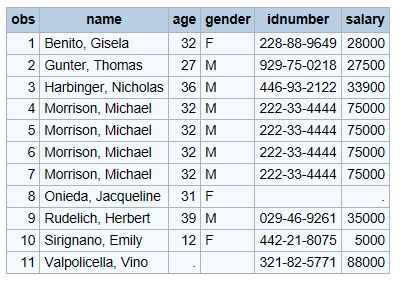

In [54]:
Image(filename='img/many2many.jpg')

The SAS Data Step using the equivalent Full Outer Join with (L=1 or R=1) for the IN= option for MERGE does not produce the same results as PROC SQL in the case of a many-to-many join.  The SAS NOTE in the log 'At least one BY group was repeated in multiple datasets while merging' is an indication you may not be producing the desired results.

````
    /******************************************************/
    /* c07_many_2_many_join.sas                           */
    /******************************************************/
    17      proc sort data = left;
    18         by name;
    19      
    20      proc sort data = right;
    21         by name;
    22      
    23      data m2m;
    24         merge left(in=l)
    25               right(in=r);
    26         by name;
    27      if (l=1 or r=1);
    NOTE: At least one BY group was repeated in multiple datasets while merging
    28      
    29      proc print data=m2m;
````

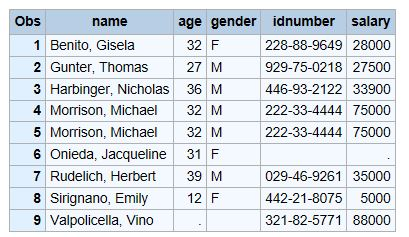

In [55]:
Image(filename='img/m2m_datastep.jpg')

## Group by: split-apply-combine Introduction

To illustrate the capabilities of panda group add the additional column in the 'left' DataFrame left['status'] as an additional categorical column.

In [56]:
left = pl.DataFrame({'name': ['Gunter, Thomas', 'Harbinger, Nicholas', 'Benito, Gisela', 'Rudelich, Herbert', \
                              'Sirignano, Emily', 'Morrison, Michael', 'Morrison, Michael', 'Onieda, Jacqueline'],
                     'age':          [27, 36, 32, 39, 22, 32, 32, 31],
                     'gender':       ['M', 'M', 'F', 'M', 'F', 'M', 'M', 'F'],
                     'status':       ['Pro', 'Amature', 'Amature', 'Pro', 'Amature', 'Amature', 'Pro', 'Pro']})

right = pl.DataFrame({'name': ['Gunter, Thomas', 'Harbinger, Nicholas', \
                               'Benito, Gisela','Rudelich, Herbert', 'Sirignano, Emily', 'Valpolicella, Vino'],
                      'id':           ['929-75-0218', '446-93-2122', \
                                       '228-88-9649', '029-46-9261', '442-21-8075', '321-82-5771'], 
                      'salary':      [27500, 33900, 28000, 35000, 5000, 80000]})

Data if often collected at one level with analysis needed at a different level.  For example, retailers collect data from invidiauls and need to aggregate to the household level.  Group by involves data splitting to create sub-populations and applying functions or transformation.  Then re-combining the grouped results into a single set of data. 

GroupBy is analogous to SAS BY group processing.  More details on polars GroupBy are located in [Chapter 8](08-Groupby.ipynb).

## Replace Missing Values with Group Means

The steps for replacing values with a group mean below are:
    1. Construct the 'df' DataFrame
    2. Drop duplicates values for df['name'] column
    3. Create the grouper 'gb1' grouping df['gender'] column values
    4. Define the function 'func' to call the .fillna missing method & replace missing values with the group mean
    5. Extract the transformed trans['salary'] column as the new df['salary'] column.

    1. Construct the 'df DataFrame

Outer Join to contruct the 'df' DataFrame on the ['name'] key value column.

In [58]:
df = get_join_indicator(left.join(right, on='name', how='full'), 'name', 'name_right')

    2. Drop duplicate rows using the 'df['name'] column values. 

In [60]:
df = df.unique(subset=['name'], keep='first')

Display the 'df' DataFrame containing missing (NaN) values for the df['salary'] column.

In [61]:
df

name,age,gender,status,name_right,id,salary,indicator
str,i64,str,str,str,str,i64,str
"""Harbinger, Nicholas""",36,"""M""","""Amature""","""Harbinger, Nicholas""","""446-93-2122""",33900,"""both"""
"""Rudelich, Herbert""",39,"""M""","""Pro""","""Rudelich, Herbert""","""029-46-9261""",35000,"""both"""
null,null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000,"""right_only"""
"""Gunter, Thomas""",27,"""M""","""Pro""","""Gunter, Thomas""","""929-75-0218""",27500,"""both"""
"""Sirignano, Emily""",22,"""F""","""Amature""","""Sirignano, Emily""","""442-21-8075""",5000,"""both"""
"""Onieda, Jacqueline""",31,"""F""","""Pro""",null,null,null,"""left_only"""
"""Benito, Gisela""",32,"""F""","""Amature""","""Benito, Gisela""","""228-88-9649""",28000,"""both"""
"""Morrison, Michael""",32,"""M""","""Amature""",null,null,null,"""left_only"""


Missing value replacement can be approached with a range a methods described <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2004%20--%20Pandas%2C%20Part%201.ipynb#Missing-Value-Replacement"> here</a> in detail.  Create the 'gb1' Series.

In [64]:
gb1 = df.group_by('gender').agg([
    pl.col('salary').mean()
])

Display the Series df['salary'] values grouped by df['gender'] values.

In [65]:
gb1

gender,salary
str,f64
"""F""",16500.0
null,80000.0
"""M""",32133.333333


PROC SQL illustrating the aggregation method (mean) grouped by the gender column.  The \_null\_ data step is used to print values to the SAS log.

````
    /******************************************************/
    /* c07_merge_both_groupby_mean_salary.sas             */
    /******************************************************/
    30       proc sql;
    31          create table sal_by_gender as
    32          select gender, mean(salary) as mean_sal
    33          from left as l,
    34               right as r
    35          where l.name = r.name
    36          group by gender;
    NOTE: Data set "WORK.sal_by_gender" has 2 observation(s) and 2 variable(s)
    37       quit;
    38       
    39       data _null_;
    40          set sal_by_gender;
    41          put _all_;

    _N_=1 _ERROR_=0 gender=F mean_sal=16500
    _N_=2 _ERROR_=0 gender=M mean_sal=32133.333333
````

    3. Create the DataFrameGroupBy (grouper) object from the df['gender'] column.

In [66]:
gb2 = df.group_by('gender')

.len() attribute used to return the number of unique levels from the group.

In [68]:
gb2.len()

gender,len
str,u32
null,1
"""M""",4
"""F""",3


    4. Fill the nulls with the mean. (In polars, unlike pandas, we don't need to do a group by here.)


In [73]:
df.with_columns(
    pl.col('salary').fill_null(
        pl.col("salary").mean().over('gender')
        
    )
)


name,age,gender,status,name_right,id,salary,indicator
str,i64,str,str,str,str,f64,str
"""Harbinger, Nicholas""",36,"""M""","""Amature""","""Harbinger, Nicholas""","""446-93-2122""",33900.0,"""both"""
"""Rudelich, Herbert""",39,"""M""","""Pro""","""Rudelich, Herbert""","""029-46-9261""",35000.0,"""both"""
null,null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000.0,"""right_only"""
"""Gunter, Thomas""",27,"""M""","""Pro""","""Gunter, Thomas""","""929-75-0218""",27500.0,"""both"""
"""Sirignano, Emily""",22,"""F""","""Amature""","""Sirignano, Emily""","""442-21-8075""",5000.0,"""both"""
"""Onieda, Jacqueline""",31,"""F""","""Pro""",null,null,16500.0,"""left_only"""
"""Benito, Gisela""",32,"""F""","""Amature""","""Benito, Gisela""","""228-88-9649""",28000.0,"""both"""
"""Morrison, Michael""",32,"""M""","""Amature""",null,null,32133.333333,"""left_only"""


## FIRST.variable and LAST.variable

The .first() attribute chained to a GroupBy for the df['status'] column as an analog to SAS' By Group processing using FIRST.variable and LAST.variable.

In [74]:
df.group_by('status').first()

status,name,age,gender,name_right,id,salary,indicator
str,str,i64,str,str,str,i64,str
"""Pro""","""Rudelich, Herbert""",39,"""M""","""Rudelich, Herbert""","""029-46-9261""",35000,"""both"""
null,null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000,"""right_only"""
"""Amature""","""Harbinger, Nicholas""",36,"""M""","""Harbinger, Nicholas""","""446-93-2122""",33900,"""both"""


In [75]:
df.group_by('status').last()

status,name,age,gender,name_right,id,salary,indicator
str,str,i64,str,str,str,i64,str
null,null,null,null,"""Valpolicella, Vino""","""321-82-5771""",80000,"""right_only"""
"""Amature""","""Morrison, Michael""",32,"""M""",null,null,null,"""left_only"""
"""Pro""","""Onieda, Jacqueline""",31,"""F""",null,null,null,"""left_only"""


## Resources

Polars group bys: https://docs.pola.rs/user-guide/concepts/expressions-and-contexts/#filter

MERGING vs. JOINING: Comparing the DATA Step with SQL, by Malachy J. Foley, University of North Carolina at Chapel Hill, located <a href="http://www2.sas.com/proceedings/sugi30/249-30.pdf"> here</a>.


SAS 9.2 SQL Procedure User's Guide located <a href="http://support.sas.com/documentation/cdl/en/sqlproc/62086/HTML/default/viewer.htm"> here</a>.

Combining SAS Data Sets: Methods: in the SAS Language Reference: Concepts Manual, Second Edition, found <a href="https://support.sas.com/documentation/cdl/en/lrcon/65287/HTML/default/viewer.htm#n1tgk0uanvisvon1r26lc036k0w7.htm"> here</a>.

## Navigation

* [Next Chapter](07-Date_and_Time.ipynb)
* [Return to Contents](00-Contents.ipynb)